In [82]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import category_encoders as ce
from scipy import stats  # Статистический пакет SciPy

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

from geopy.distance import great_circle  # Расчёт расстояний на основе координат

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for Kaggle
#for dirname, _, filenames in os.walk('/kaggle/input'):
for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

data/hotels_test.csv
data/hotels_train.csv
data/submission.csv


### Функции для статистических тестов

In [83]:
# Заданный уровень значимости
alpha = 0.05


# Функция для принятия решения об отклонении нулевой гипотезы
def function_hypothesis(p):
    """
    Функция выводит решение о нулевой гипотезе на основе p-значения.

    Параметры:
    p (float): p-значение, полученное из статистического теста.
    """
    print(f'p-value = {p:.3f}')
    if p <= alpha:
        print(f'p-значение меньше, чем заданный уровень значимости {alpha:.2f}. '
              f'Отвергаем нулевую гипотезу в пользу альтернативной.')
    else:
        print(f'p-значение больше, чем заданный уровень значимости {alpha:.2f}. '
              f'У нас нет оснований отвергнуть нулевую гипотезу.')
        
# Функция для принятия решения о нормальности распределения
def function_normality(p):
    """
    Функция выводит решение о нормальности распределения на основе p-значения.

    Параметры:
    p (float): p-значение, полученное из теста на нормальность.
    """
    print(f'p-value = {p:.3f}')
    if p <= alpha:
        print(f'p-значение меньше, чем заданный уровень значимости {alpha:.2f}. '
              f'Распределение отлично от нормального.')
    else:
        print(f'p-значение больше, чем заданный уровень значимости {alpha:.2f}. '
              f'Распределение является нормальным.')
        
def shapiro(group, i):
    """
    Проводит тест Шапиро-Уилка для проверки нормальности распределения в группе.

    Параметры:
    group (array-like): Группа данных, которую необходимо проверить на нормальность.
    i (int): Номер группы для вывода информации.

    Возвращает:
    None: Функция не возвращает значение, но выводит результаты теста и решение о нормальности.
    """
    # Выводим номер группы
    print(f'Группа {i}: ')

    # Выполняем тест Шапиро-Уилка
    result = stats.shapiro(group)

    # Передаем p-значение в функцию для принятия решения о нормальности
    function_normality(result[1])

def stat_test(test, groups, alt='two-sided'):
    """
    Функция проводит выбранный статистический тест и возвращает решение о гипотезе.

    Параметры:
    test (str): Название теста ('mannwhitneyu', 'sign_test', 'wilcoxon', 'kruskal', 'friedman').
    groups (tuple of array-like): Наборы данных для тестирования.
    alt (str, optional): Альтернатива для одностороннего или двустороннего теста ('two-sided','greater', 'less'). По умолчанию 'two-sided'. 

    Возвращает:
    str: Решение о нулевой гипотезе.
    """
    if test == 'mannwhitneyu':
        _, p = stats.mannwhitneyu(*groups, alternative=alt)
    elif test == 'sign_test':
        _, p = stats.descriptivestats.sign_test(*groups, alternative=alt)
    elif test == 'wilcoxon':
        _, p = stats.wilcoxon(*groups, alternative=alt)
    elif test == 'kruskal':
        _, p = stats.kruskal(*groups)
    elif test == 'friedman':
        _, p = stats.friedmanchisquare(*groups, alternative=alt)
    return function_hypothesis(p)

### Функции для визуализации

In [84]:
# Построение гистограмм для нескольких групп данных
def distribution(groups):
    """
    Функция строит гистограммы распределения нескольких групп данных.

    Параметры:
    groups (list for array-like): Список групп данных.
    """
    # Создаем фигуру с двумя подграфиками
    fig, axes = plt.subplots(1, len(groups), figsize=(10, len(groups)))
    for idx,group in enumerate(groups):
        # Строим гистограмму для группы данных
        axes[idx].hist(group, bins=30, density=True)
        axes[idx].set_title(f"group{idx+1}")          

        plt.tight_layout()  
    
# Барплот и круговая диаграмма для признака
def pie_bar(name, title, x_name, df):
    """
    Функция строит круговую диаграмму и барплот для заданного признака.

    Параметры:
    name (str): Имя столбца данных, который нужно визуализировать.
    title (str): Заголовок графика.
    x_name (str): Название оси X для барплота.
    df (dataframe): используемый датасет.
    """
    # Создаем фигуру с двумя подграфиками
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Считаем количество значений для каждого уникального значения в столбце 'name'
    counts = df[df['sample'] == 1][name].value_counts()

    # Строим круговую диаграмму
    axes[0].pie(
        counts,          
        labels=counts.index,  
        startangle=90,      
        autopct='%1.f%%',    
    )
    axes[0].set_title(title)     

    # Группируем данные по значению 'name' и вычисляем медиану оценки
    group = df[df['sample'] == 1].groupby(name)['reviewer_score'].median().reset_index()

    # Строим барплот для признака
    sns.barplot(
        x=group[name],     
        y=group['reviewer_score'],  
        ax=axes[1]          
    )
    axes[1].set_title(title)    
    axes[1].set_xlabel(x_name) 
    axes[1].set_ylabel('Оценка')
    plt.tight_layout()

In [85]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [86]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [87]:
# Подгрузим наши данные из соревнования

#DATA_DIR = '/kaggle/input/sf-booking/'
DATA_DIR = 'data/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [88]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [89]:
df_train.head(4)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540


In [90]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [91]:
df_test.head(4)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298


In [92]:
sample_submission.head(4)

,reviewer_score,id
0,8.823,488440
1,7.407,274649
2,8.193,374688
3,9.307,404352


In [93]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewer_score  128935 non-null  float64
 1   id              128935 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 2.0 MB


#### Проверим наличие дубликатов

In [94]:
dupl_columns = list(df_train.columns)

mask = df_train.duplicated(subset=dupl_columns)
h_duplicates = df_train[mask]
display(f'Число найденных дубликатов: {h_duplicates.shape[0]}')

'Число найденных дубликатов: 307'

#### Удалим дубликаты

In [95]:
df_train = df_train.drop_duplicates(subset=dupl_columns)

In [96]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = pd.concat([df_test,df_train], ignore_index=True, sort=False) # объединяем

In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

### Преобразование признаков, связанных с временем

Преобразуем  признак ***days_since_review*** в числовой

In [98]:
data['days_since_review'] = data['days_since_review'].apply(lambda day : int(day.split(' ')[0]))
display(data['days_since_review'].head(4))

0     13
1    234
2    616
3    656
Name: days_since_review, dtype: int64

Преобразуем признак ***review_date*** в формат ***datetime***

In [99]:
data['review_date'] = pd.to_datetime(data['review_date'])
display(data['review_date'].head(4))

0   2017-07-21
1   2016-12-12
2   2015-11-26
3   2015-10-17
Name: review_date, dtype: datetime64[ns]

#### Создадим признак ***review_year*** (год написания отзыва) из признака ***review_date***

In [100]:
data['review_year'] = data['review_date'].dt.year

#### Создадим признак ***is_weekend***, который показывает, оставлен ли отзыв в выходной день, из признака ***review_date***

In [101]:
data['is_weekend'] = data['review_date'].apply(lambda day: 1 if day.weekday()==5 or day.weekday() == 6 else 0)
#display(data['is_weekend'])

#### Удалим исходный признак 'review_date'

In [102]:
data.drop('review_date', axis=1, inplace=True)

### Посчитаем пропуски в координатах отелей.

In [103]:
empty_coords = data[(data['lat'].isna() == True) | (data['lng'].isna() == True)]
display(empty_coords.shape[0])

3268

3268 пропусков в координатах отелей. Проверим названия отелей, у которых нет координат.

In [104]:
display(empty_coords['hotel_name'].unique().shape[0])
display(empty_coords['hotel_name'].unique())

17

array(['Hotel Atlanta', 'City Hotel Deutschmeister',
       'Holiday Inn Paris Montmartre',
       'Fleming s Selection Hotel Wien City', 'Hotel City Central',
       'Cordial Theaterhotel Wien', 'NH Collection Barcelona Podium',
       'Hotel Daniel Vienna', 'Maison Albar Hotel Paris Op ra Diamond',
       'Mercure Paris Gare Montparnasse',
       'Hotel Pension Baron am Schottentor',
       'Austria Trend Hotel Schloss Wilhelminenberg Wien',
       'Renaissance Barcelona Hotel',
       'Derag Livinghotel Kaiser Franz Joseph Vienna', 'Roomz Vienna',
       'Hotel Park Villa', 'Hotel Advance'], dtype=object)

Добавим координаты этих отелей вручную из открытых источников.

In [105]:
fill_hotels_coords = pd.DataFrame({'hotel_name':['Austria Trend Hotel Schloss Wilhelminenberg Wien',
'Holiday Inn Paris Montmartre', 'Fleming s Selection Hotel Wien City',
'Hotel Atlanta', 'Maison Albar Hotel Paris Op ra Diamond',
'Derag Livinghotel Kaiser Franz Joseph Vienna', 'Hotel City Central',
'NH Collection Barcelona Podium', 'City Hotel Deutschmeister',
'Hotel Daniel Vienna', 'Roomz Vienna', 'Hotel Pension Baron am Schottentor',
'Mercure Paris Gare Montparnasse', 'Hotel Park Villa', 'Hotel Advance',
'Renaissance Barcelona Hotel', 'Cordial Theaterhotel Wien'],
                              
'lat':[48.229047, 48.888945, 48.897508, 48.220819, 48.877885, 
       48.246288, 48.213632, 48.214636, 48.222147, 48.188816, 
       48.222970, 48.216753, 48.838038, 46.991676, 28.103670, 41.392437, 48.209565], 

'lng':[16.284445, 2.333260, 2.207706, 16.356070, 2.324035, 16.341359, 
       16.379934, 16.380054, 16.366343, 16.383355, 16.393311, 16.359726, 
       2.318824, 3.154911, 113.013415, 2.167519, 16.351598]})

data['lat'] = data['lat'].fillna(data['hotel_name'].map(fill_hotels_coords.set_index('hotel_name')['lat']))
data['lng'] = data['lng'].fillna(data['hotel_name'].map(fill_hotels_coords.set_index('hotel_name')['lng']))

display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   average_score                               515431 non-null  float64
 3   hotel_name                                  515431 non-null  object 
 4   reviewer_nationality                        515431 non-null  object 
 5   negative_review                             515431 non-null  object 
 6   review_total_negative_word_counts           515431 non-null  int64  
 7   total_number_of_reviews                     515431 non-null  int64  
 8   positive_review                             515431 non-null  object 
 9   review_total_positive_word_counts           515431 non-null  int64  
 

None

In [106]:
# Тест
#display(data[data['hotel_name'] == 'Austria Trend Hotel Schloss Wilhelminenberg Wien']['lng'])

### Создадим признаки "Город отеля" ('hotels_city') и "Страна отеля" ('hotels_country') из признака 'hotel_address'

In [107]:
# Извлекаем город, в котором находится отель
data['hotel_city'] = data['hotel_address'].apply(lambda x: x.split()[-5] if 'United Kingdom' in x else x.split()[-2])

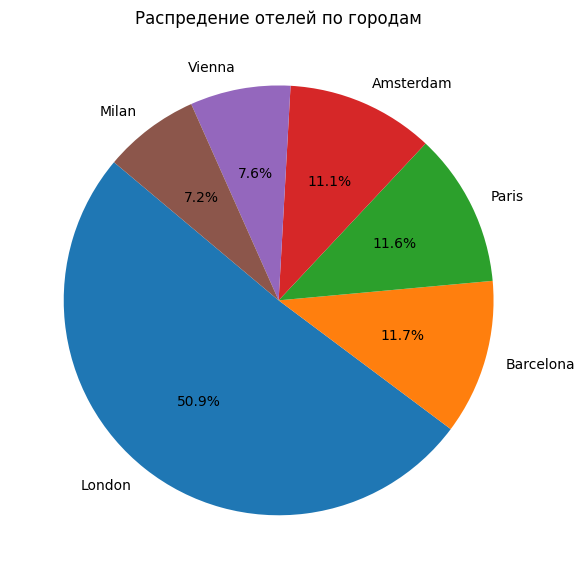

In [108]:
# Смотрим распределение отелей по городам
fig, axes = plt.subplots(figsize=(6, 6))
city_counts = data.hotel_city.value_counts()

plt.pie(
    city_counts,
    labels = city_counts.index,
    autopct='%1.1f%%',
    startangle=140
);

plt.title("Распредение отелей по городам")
plt.tight_layout()

Видно, что половина всех отелей находится в Лондоне.

Посмотрим оценку отеля в разрезе города нахождения

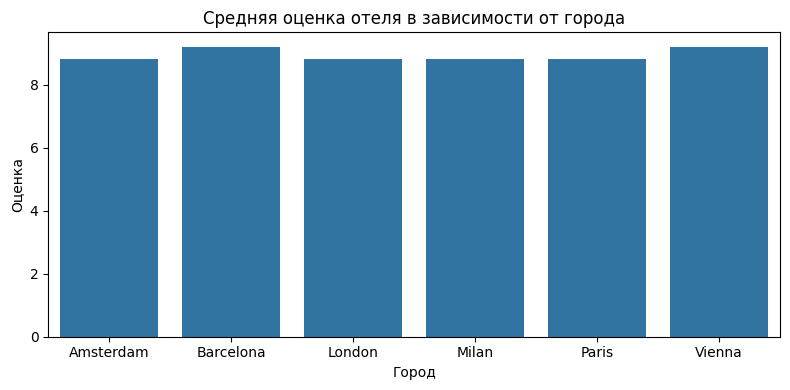

In [109]:
fig, axes = plt.subplots(figsize=(8, 4))

# Группируем по названию отеля и расчитываем медианную оценку
city_score = data[data['sample'] == 1].groupby('hotel_city')['reviewer_score'].median().reset_index()

# Строим барплот
sns.barplot(
    x=city_score.hotel_city, 
    y=city_score['reviewer_score'])

plt.title('Средняя оценка отеля в зависимости от города')
plt.xlabel('Город')
plt.ylabel('Оценка')
plt.tight_layout();

Из графиков нельзя сделать вывод о зависимости оценки от города. Проведем статистические тесты.

In [110]:
# Группы для сравнения
df_amsterdam = data[data['hotel_city']=='Amsterdam']['reviewer_score']
df_barcelona = data[data['hotel_city']=='Barcelona']['reviewer_score']
df_london = data[data['hotel_city']=='London']['reviewer_score']
df_milan = data[data['hotel_city']=='Milan']['reviewer_score']
df_paris = data[data['hotel_city']=='Paris']['reviewer_score']
df_vienna = data[data['hotel_city']=='Vienna']['reviewer_score']

#print(df_paris)

# проверка признаков на нормальность
shapiro(df_amsterdam,1)
shapiro(df_barcelona,2)
shapiro(df_london,3)
shapiro(df_milan,4)
shapiro(df_paris,5)
shapiro(df_vienna,6)

Группа 1: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.
Группа 2: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.
Группа 3: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.
Группа 4: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.
Группа 5: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.
Группа 6: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.


C:\Users\Дмитрий\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 57212.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Дмитрий\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 60149.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Дмитрий\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 262300.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Дмитрий\A

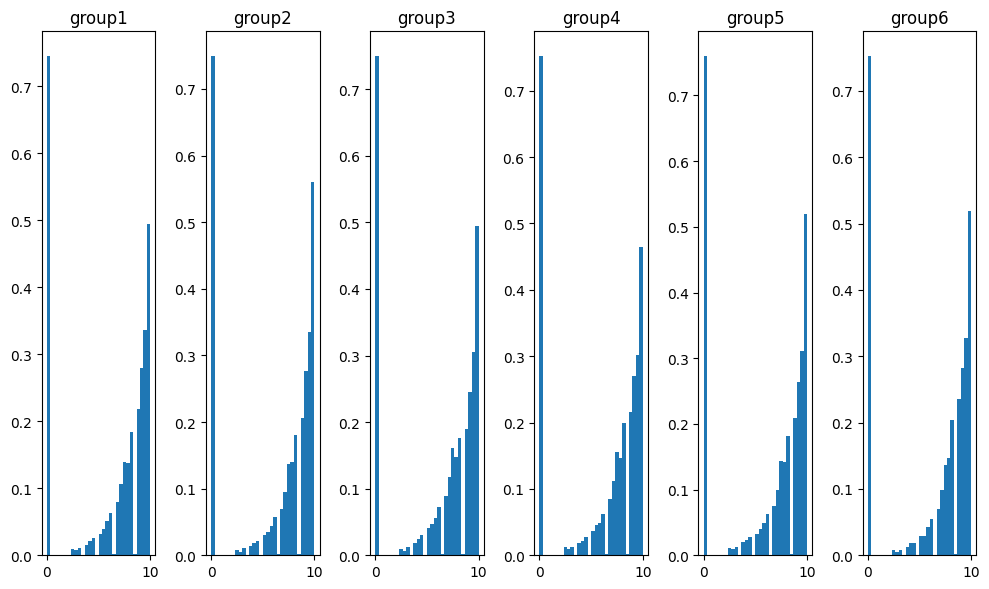

In [111]:
# Построим графики распределений
distribution([df_amsterdam, df_barcelona, df_london, df_milan, df_paris, df_vienna])

In [112]:
# Распределение признаков отлично от нормального, групп 6, используем тест Краскела-Уоллиса
stat_test('kruskal', [df_amsterdam, df_barcelona, df_london, df_milan, df_paris, df_vienna])

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Тест показал, что оценка зависит от города. Оставляем признак.

###  Извлечем признак 'hotel_country', чтобы знать страну, в который находится отель

In [113]:
data['hotel_country'] = data['hotel_address'].apply(lambda x: ' '.join(x.split()[-2:]) if 'United Kingdom' in x else x.split()[-1])

Посмотрим оценку отеля в разрезе страны нахождения

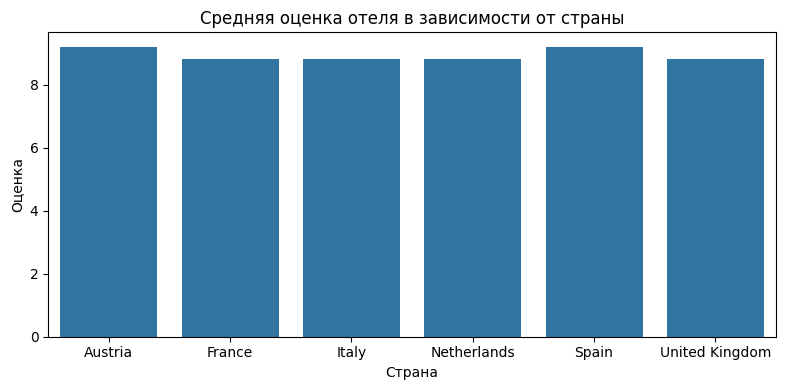

In [114]:
fig, axes = plt.subplots(figsize=(8, 4))

# Группируем по названию отеля и расчитываем медианную оценку
country_score = data[data['sample'] == 1].groupby('hotel_country')['reviewer_score'].median().reset_index()

# Строим барплот
sns.barplot(
    x=country_score.hotel_country, 
    y=country_score['reviewer_score'])

plt.title('Средняя оценка отеля в зависимости от страны')
plt.xlabel('Страна')
plt.ylabel('Оценка')
plt.tight_layout();

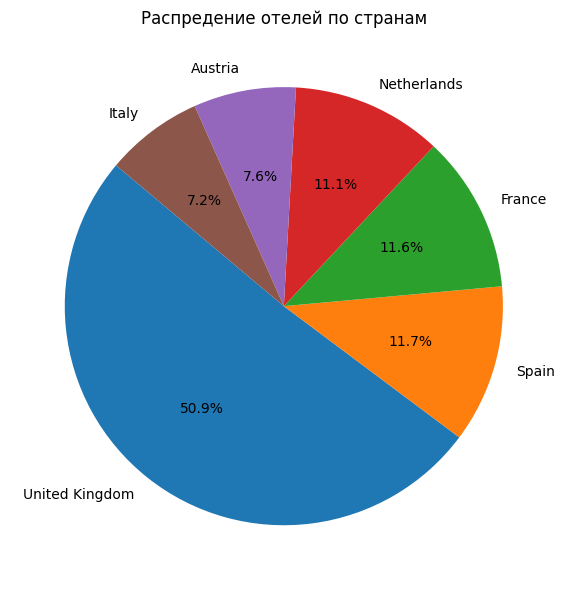

In [115]:
fig, axes = plt.subplots(figsize=(6, 6))
# Считаем сколько данных об отелях по каждой стране
country_counts = data.hotel_country.value_counts()

# Строим круговую диаграмму
plt.pie(
    country_counts,
    labels = country_counts.index,
    autopct='%1.1f%%',
    startangle=140
);

plt.title("Распредение отелей по странам")
plt.tight_layout()

Из графиков нельзя сделать вывод о зависимости оценки от страны. Проведем статистические тесты.

In [116]:
# Группы для сравнения
df_uk = data[data['hotel_country']=='United Kingdom']['reviewer_score']
df_italy = data[data['hotel_country']=='Italy']['reviewer_score']
df_austria = data[data['hotel_country']=='Austria']['reviewer_score']
df_netherlands = data[data['hotel_country']=='Netherlands']['reviewer_score']
df_france = data[data['hotel_country']=='France']['reviewer_score']
df_spain = data[data['hotel_country']=='Spain']['reviewer_score']

#print(df_italy)

# проверка признаков на нормальность
shapiro(df_uk,1)
shapiro(df_italy,2)
shapiro(df_austria,3)
shapiro(df_netherlands,4)
shapiro(df_france,5)
shapiro(df_spain,6)

Группа 1: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.
Группа 2: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.
Группа 3: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.
Группа 4: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.
Группа 5: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.
Группа 6: 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.


C:\Users\Дмитрий\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 262300.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Дмитрий\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 37206.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Дмитрий\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 38938.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Дмитрий\A

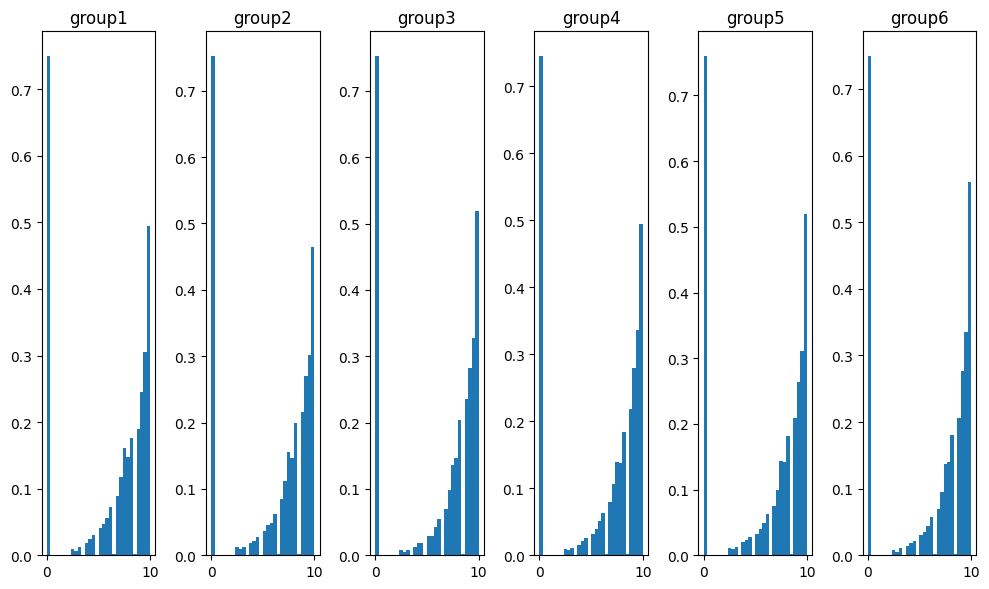

In [117]:
# Визуально оцениваем распределение 
distribution ([df_uk, df_italy, df_austria, df_netherlands, df_france, df_spain])    

In [118]:
# Распределение признаков отлично от нормального, групп 6, используем тест Краскела-Уоллиса
stat_test('kruskal', [df_uk, df_italy, df_austria, df_netherlands, df_france, df_spain])

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Тест показал, что оценка зависит от страны нахождения. Оставляем признак.

### Закодируем признаки 'hotel_city' и 'hotel_country'.

In [119]:
# hotel_country
encoder = ce.OneHotEncoder(cols=['hotel_country'], use_cat_names=True)
type_bin = encoder.fit_transform(data['hotel_country'])
data = pd.concat([data, type_bin], axis=1)

# hotel_city
encoder = ce.OneHotEncoder(cols=['hotel_city'], use_cat_names=True)
type_bin = encoder.fit_transform(data['hotel_city'])
data = pd.concat([data, type_bin], axis=1)

In [120]:
# Удалим исходные признаки
data.drop(columns=['hotel_country', 'hotel_city', 'hotel_address'], axis=1,inplace=True)
display(data.head(1))

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,hotel_country_Spain,hotel_country_United Kingdom,hotel_country_France,hotel_country_Austria,hotel_city_Milan,hotel_city_Amsterdam,hotel_city_Barcelona,hotel_city_London,hotel_city_Paris,hotel_city_Vienna
0,904,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,...,0,0,0,0,1,0,0,0,0,0


In [121]:
data.nunique(dropna=False)

additional_number_of_scoring                     480
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1489
lng                                             1489
sample                                             2
reviewer_score                                    38
review_year                                        3
is_weekend                                         2
hotel_country_Italy                           

<Axes: >

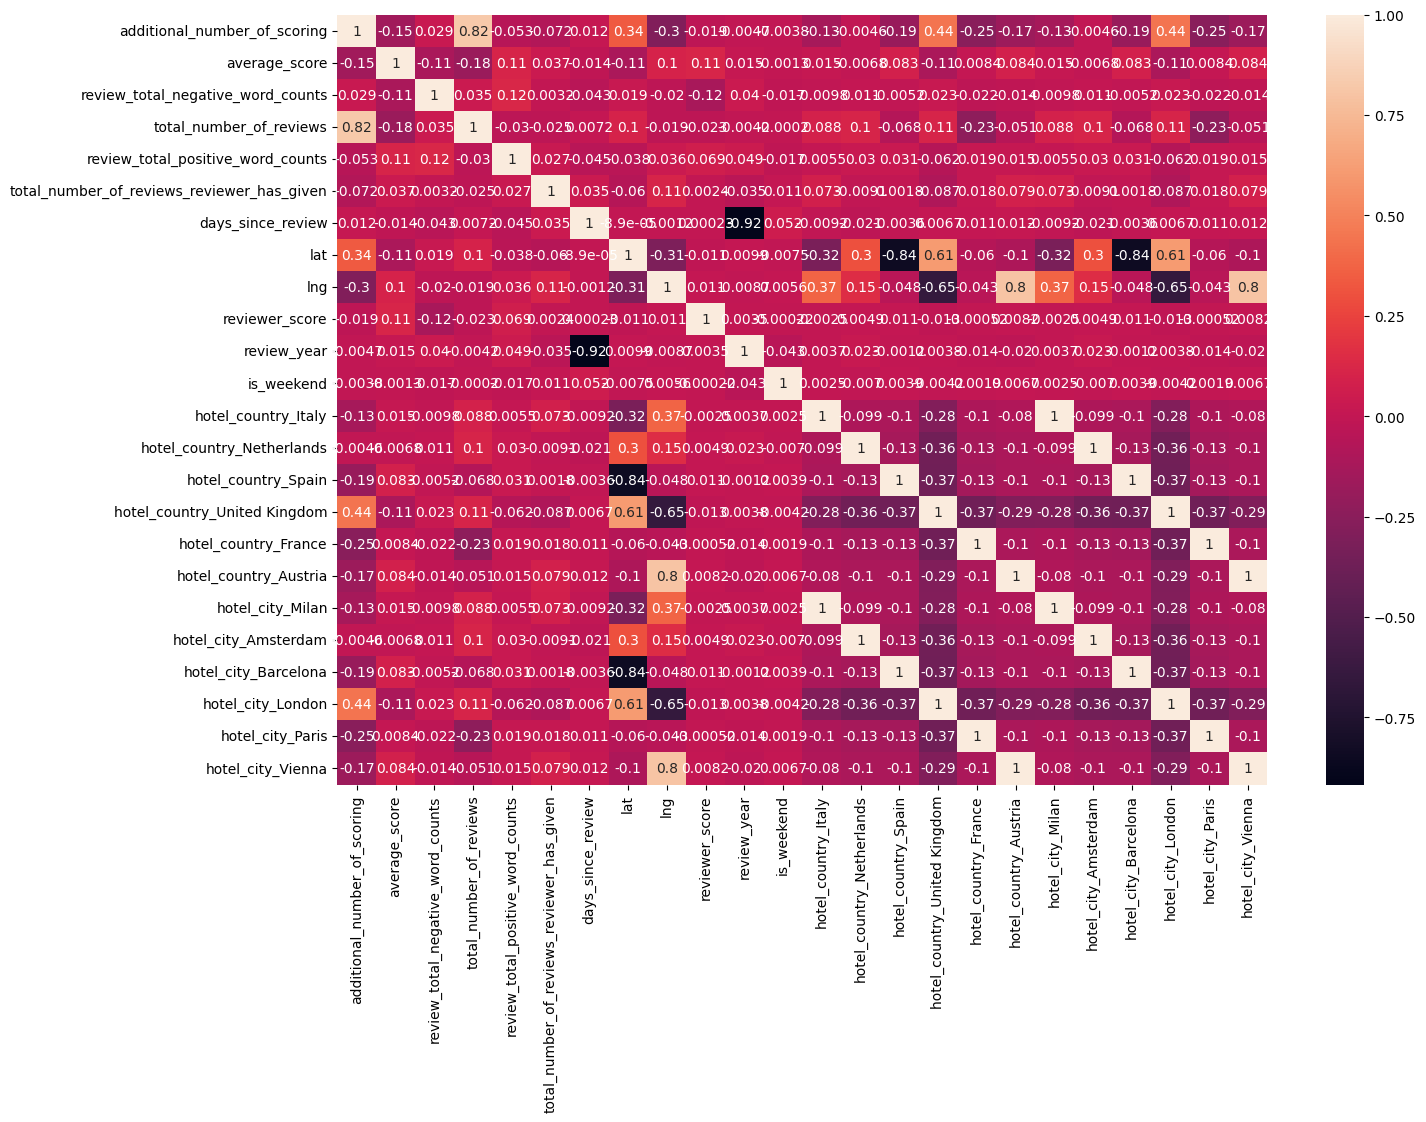

In [122]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(numeric_only=True), annot=True)
# for Kaggle
#sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [123]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [124]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 25 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   review_total_negative_word_counts           515431 non-null  int64  
 3   total_number_of_reviews                     515431 non-null  int64  
 4   review_total_positive_word_counts           515431 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 6   days_since_review                           515431 non-null  int64  
 7   lat                                         515431 non-null  float64
 8   lng                                         515431 non-null  float64
 9   sample                                      515431 non-null  int64  
 

In [125]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [126]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [127]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 24), (386496, 24), (386496, 23), (309196, 23), (77300, 23))

In [128]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [129]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [130]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished


In [131]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.9543364454506251


<Axes: >

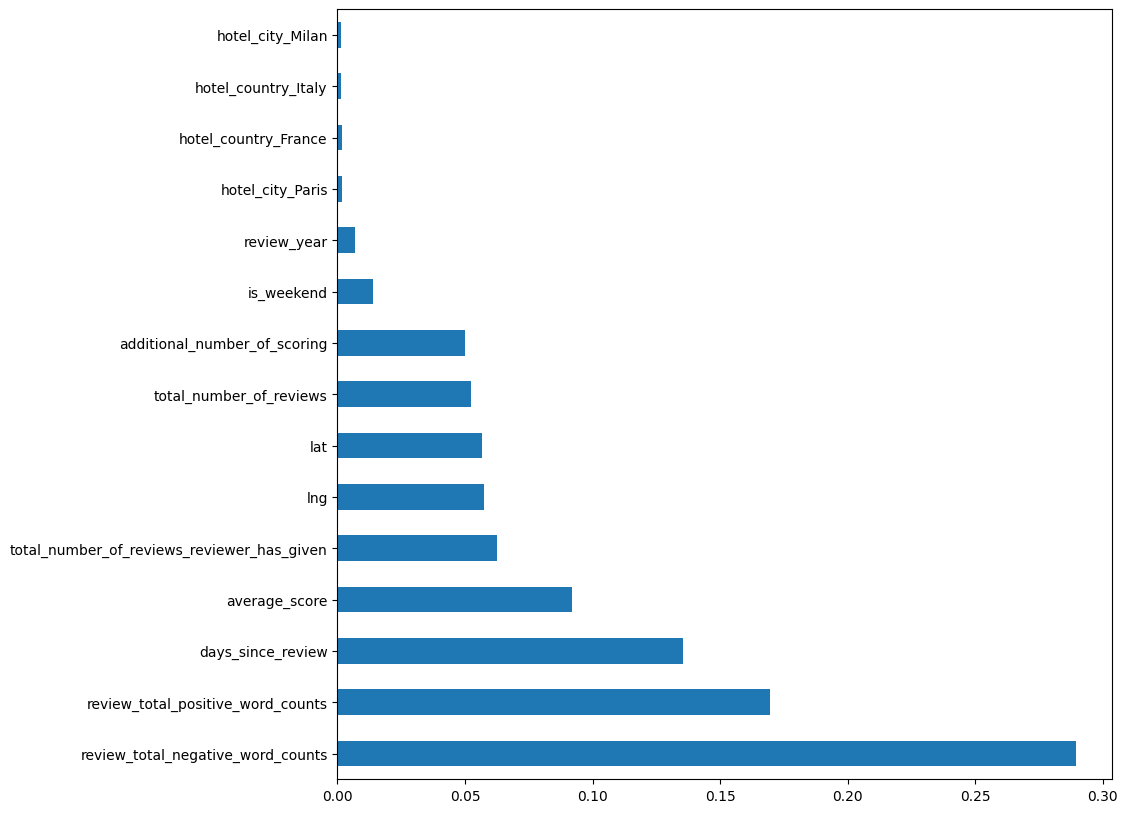

In [132]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [133]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,reviewer_score,...,hotel_country_Spain,hotel_country_United Kingdom,hotel_country_France,hotel_country_Austria,hotel_city_Milan,hotel_city_Amsterdam,hotel_city_Barcelona,hotel_city_London,hotel_city_Paris,hotel_city_Vienna
102599,947,8.7,21,8177,0,1,315,52.351114,4.841163,0.0,...,0,0,0,0,0,1,0,0,0,0
74918,713,8.3,0,2826,13,4,649,51.524139,-0.138081,0.0,...,0,1,0,0,0,0,0,1,0,0
67353,244,9.3,0,1835,48,1,686,41.392095,2.158493,0.0,...,1,0,0,0,0,0,1,0,0,0
125250,205,9.1,54,1875,90,3,207,41.389213,2.172601,0.0,...,1,0,0,0,0,0,1,0,0,0
11488,252,9.1,24,1166,26,4,690,51.507690,-0.147136,0.0,...,0,1,0,0,0,0,0,1,0,0
89367,989,8.4,0,4660,18,7,715,51.493847,-0.191758,0.0,...,0,1,0,0,0,0,0,1,0,0
62413,258,7.8,66,2521,5,7,502,41.328376,2.112964,0.0,...,1,0,0,0,0,0,1,0,0,0
111831,688,7.8,0,2147,9,3,709,51.531979,-0.061598,0.0,...,0,1,0,0,0,0,0,1,0,0
7635,355,8.0,8,1786,13,4,199,51.514362,-0.139448,0.0,...,0,1,0,0,0,0,0,1,0,0
44285,2288,8.1,0,9568,10,8,475,51.511099,-0.120867,0.0,...,0,1,0,0,0,0,0,1,0,0


In [134]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [135]:
sample_submission

,reviewer_score,id
0,8.823,488440
1,7.407,274649
2,8.193,374688
3,9.307,404352
4,9.704,451596
...,...,...
128930,8.890,495812
128931,8.523,315577
128932,8.303,511968
128933,9.776,303386


In [136]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.3s finished


In [137]:
predict_submission

array([8.825, 7.459, 8.208, ..., 8.225, 9.693, 7.024], shape=(128935,))

In [138]:
list(sample_submission)

['reviewer_score', 'id']

In [139]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('data/submission.csv', index=False)
# for Kaggle
#sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.825,488440
1,7.459,274649
2,8.208,374688
3,9.360,404352
4,9.764,451596
5,8.410,302161
6,8.123,317079
7,7.689,13963
8,8.708,159785
9,8.011,195089
